# 02 - Implementation of Conditional GAN (C-GAN)
 
 
    Conditional GAN from "https://arxiv.org/pdf/1411.1784.pdf" (2014, M. Mirza et. al.)

    Kernel-author: Jackson Kang @ Deep-learning Lab. (Handong Global University, S.Korea)

    Author-email:  mskang@handong.edu

    python and pytorch version: python=3.7, pytorch=1.6

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from matplotlib.pyplot import imshow, imsave

%matplotlib inline

# Step 00. Hyperparameter Setting

In [2]:
# Dataset Info.
dataset_path = '~/datasets'
kwargs = {'num_workers': 1, 'pin_memory': True} 
noise_dim=100
sample_dim = 784
num_class = 10

# CUDA and GPU Info.
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

# Training info.
batch_size = 100
test_batch_size = 10
lr = 0.0002
epochs = 30
discriminator_train_step = 1
# Model hyperparameter Info.

# Step 01. Download Dataset

In [3]:
mnist_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)
train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=True,  **kwargs)

# Step 02. Define Model

In [4]:
# Simple MLP Generator

class Generator(nn.Module):
    
    def __init__(self, input_dim, condition_dim, output_dim):
        super(Generator, self).__init__()
        
        self.linears = nn.Sequential(
        
            nn.Linear(input_dim+condition_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )
        
        
    def forward(self, x, conditions):
        return self.linears(torch.cat((x, conditions), dim=1))

In [5]:
class Discriminator(nn.Module):
    
    def __init__(self, input_dim, condition_dim, output_dim):
        super(Discriminator, self).__init__()
        
        self.linears = nn.Sequential(
        
            nn.Linear(input_dim + condition_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Sigmoid()
        )
        

    def forward(self, x, conditions):
        return self.linears(torch.cat((x, conditions), dim=1))

In [6]:
G = Generator(input_dim=noise_dim, condition_dim=num_class, output_dim=sample_dim).to(DEVICE)
D = Discriminator(input_dim=sample_dim, condition_dim=num_class, output_dim=1).to(DEVICE)

# Step 03. Define Loss function and optimizer

In [7]:
criterion = nn.BCELoss()

D_optim = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
G_optim = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

# Step 04. Train Conditional GAN

In [8]:
def convert_to_one_hot(conditions, shape):
    batch_size, num_of_class = shape
    zero_labels = torch.zeros((batch_size, num_of_class)).to(DEVICE)
    for idx, c in enumerate(conditions):
        zero_labels[idx, c]=1
    return zero_labels
    
def train_D(D, G, x, condition, noise, D_labels, D_fakes):
    
    x_fake = G(noise, condition)
    y_hat = D(x, condition)
    y_hat_fake = D(x_fake, condition)
    
    return criterion(y_hat, D_labels) + criterion(y_hat_fake, D_fakes)

def train_G(D, G, D_labels, condition, noise):
    return criterion(D(G(noise, condition), condition), D_labels)

In [9]:
print("Start training Conditional GAN...")

D_labels = torch.ones([batch_size, 1]).to(DEVICE) #  Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

for epoch in range(epochs):
    epoch_G_loss = 0
    epoch_D_loss = 0
    
    for batch_idx, (x, condition) in enumerate(train_loader):
        x = x.view(batch_size, sample_dim).to(DEVICE)
        condition_input = convert_to_one_hot(condition, shape=(batch_size, num_class)).float().to(DEVICE)
        noise = torch.randn((batch_size, noise_dim)).to(DEVICE)
        
        # Train Discriminator
        G.eval()
        for _ in range(discriminator_train_step):
            D_optim.zero_grad()
            D_loss = train_D(D, G, x, condition_input, noise, D_labels, D_fakes)
            D_loss.backward()
            D_optim.step()
        
        
        # Train Generator
        G.train()
        G_optim.zero_grad()
        G_loss = train_G(D, G, D_labels, condition_input, noise)
        G_loss.backward()
        G_optim.step()
        
        epoch_G_loss += G_loss.item()
        epoch_D_loss += D_loss.item()
        
    print("\tEpoch", epoch + 1, "\tGenerator Loss: ", epoch_G_loss / (batch_idx*batch_size), "\tDiscriminator Loss: ", epoch_D_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training Conditional GAN...
	Epoch 1 	Generator Loss:  0.012194961779354412 	Discriminator Loss:  0.008625478311651736
	Epoch 2 	Generator Loss:  0.015152533381232037 	Discriminator Loss:  0.009306460157260672
	Epoch 3 	Generator Loss:  0.01599416515066946 	Discriminator Loss:  0.009621359301926894
	Epoch 4 	Generator Loss:  0.015494706315269852 	Discriminator Loss:  0.009787569186325264
	Epoch 5 	Generator Loss:  0.012538448339312622 	Discriminator Loss:  0.011018242304631585
	Epoch 6 	Generator Loss:  0.011561027122459348 	Discriminator Loss:  0.011490662345703138
	Epoch 7 	Generator Loss:  0.011026959274965454 	Discriminator Loss:  0.011835373110683613
	Epoch 8 	Generator Loss:  0.01071379640713359 	Discriminator Loss:  0.012078896080313222
	Epoch 9 	Generator Loss:  0.010379180852976785 	Discriminator Loss:  0.012320750338804344
	Epoch 10 	Generator Loss:  0.009974258837596403 	Discriminator Loss:  0.012586404519009472
	Epoch 11 	Generator Loss:  0.009595797556469556 	Discrim

# Step 05. Generate image samples

In [10]:
def get_sample_image(G, noise_dim=100):
    """
        save sample 100 images
    """
    img = np.zeros([280, 280])
    conditions = torch.arange(num_class, dtype=torch.long)
    zero_labels = torch.zeros([test_batch_size, num_class])
    
    for j in range(10):
        z = torch.randn(test_batch_size, noise_dim).to(DEVICE)
        condition = torch.zeros([10, 10]).to(DEVICE)
        condition[:, j] = 1
        x_hat = G(z, condition).view(test_batch_size, 28, 28)
        result = x_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

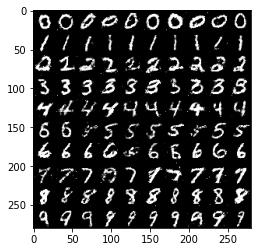

In [11]:
G.eval()
imshow(get_sample_image(G, noise_dim=noise_dim), cmap='gray')